LightGBM Model: DCH Clearing Price Prediction
Data shape: (3635, 2)
Target: DCH_Clearing_Price
Features: ['EFA block of the day', 'Average DAM price in EFA block']

Data Split:
   Training: 2908 samples
   Testing: 727 samples

Time Series Cross Validation (5 folds):
   Time Series CV R² Scores: [-0.11423975 -0.13655571  0.18264049  0.1041281  -0.26818267]
   Mean CV R²: -0.0464
   Std CV R²: 0.1656
   Note: Using TimeSeriesSplit for proper temporal validation

Training Final Model...

Model Performance:
   Test R²: -0.0221
   Test MAE: 1.4287
   Test RMSE: 2.0404

Feature Importance:
   Average DAM price in EFA block: 1821.0000
   EFA block of the day: 198.0000


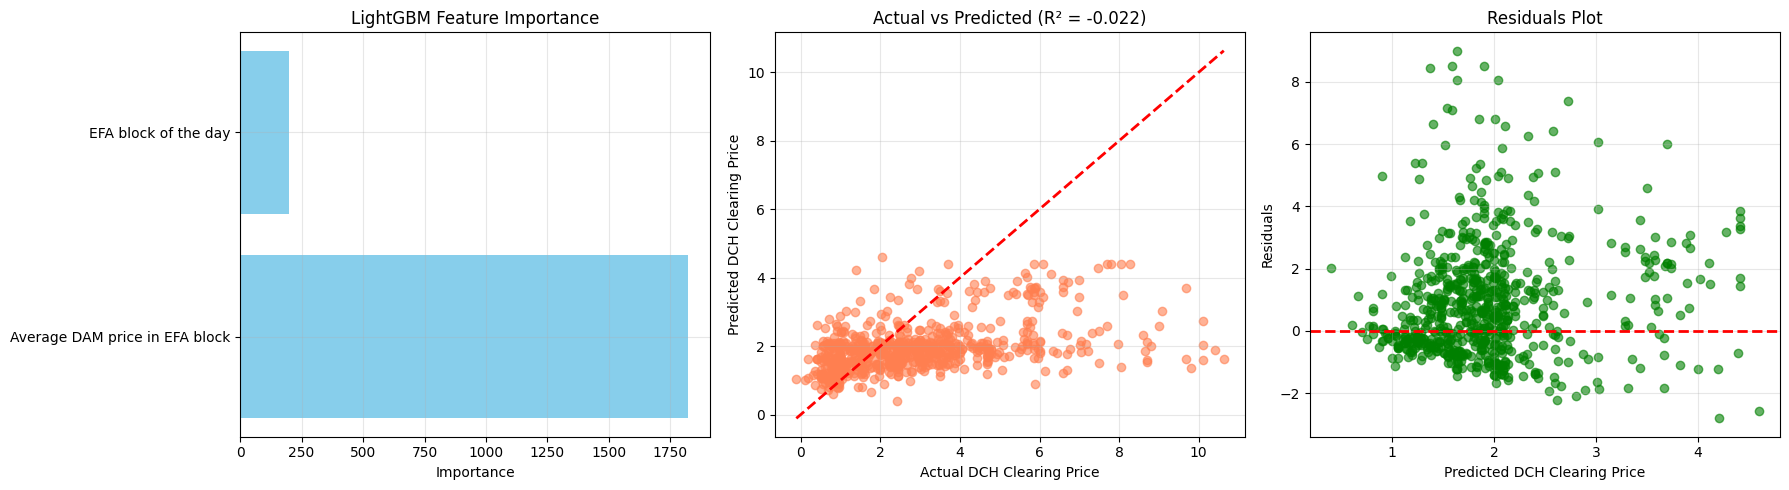


LIGHTGBM MODEL SUMMARY
Model: LightGBM Regressor
Features: 2 features
Training samples: 2908
Test samples: 727
Cross-validation R²: -0.0464 ± 0.1656
Test R²: -0.0221 (-2.2% variance explained)
Test MAE: ±1.4287
Test RMSE: 2.0404
WEAK MODEL: Limited predictive relationship!

Most important feature: Average DAM price in EFA block
LightGBM successfully trained and evaluated!


In [14]:
# LightGBM Model: Predict DCH Clearing Price using EFA Block + DAM Price
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

print("LightGBM Model: DCH Clearing Price Prediction")
print("="*60)

# 1. Load and prepare data
df = pd.read_csv('DAM_DCH_Merged_Prices.csv')
df.columns = df.columns.str.strip()  # Clean column names

# Features and target
features = ['EFA block of the day', 'Average DAM price in EFA block']
target = 'DCH_Clearing_Price'

X = df[features]
y = df[target]

print(f"Data shape: {X.shape}")
print(f"Target: {target}")
print(f"Features: {features}")


# 2. Chronological 80:20 Train-Test Split
split_index = int(0.8 * len(df))
split_date = df.iloc[split_index]['Delivery day']

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"\nData Split:")
print(f"   Training: {X_train.shape[0]} samples")
print(f"   Testing: {X_test.shape[0]} samples")

# 3. LightGBM Model Setup
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbose=-1
)

# 4. Time Series Cross Validation
print(f"\nTime Series Cross Validation (5 folds):")
# Use TimeSeriesSplit for proper time series validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(
    lgb_model, X_train, y_train, 
    cv=tscv, scoring='r2', n_jobs=-1
)

print(f"   Time Series CV R² Scores: {cv_scores}")
print(f"   Mean CV R²: {cv_scores.mean():.4f}")
print(f"   Std CV R²: {cv_scores.std():.4f}")
print(f"   Note: Using TimeSeriesSplit for proper temporal validation")

# 5. Train Final Model
print(f"\nTraining Final Model...")
lgb_model.fit(
    X_train, y_train,
    categorical_feature=['EFA block of the day']
)

# 6. Test Set Predictions
y_pred = lgb_model.predict(X_test)

# 7. Model Evaluation
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Performance:")
print(f"   Test R²: {r2:.4f}")
print(f"   Test MAE: {mae:.4f}")
print(f"   Test RMSE: {rmse:.4f}")

# 8. Feature Importance
feature_importance = lgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print(f"\nFeature Importance:")
for _, row in importance_df.iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.4f}")

# 9. Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Feature Importance
axes[0].barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('LightGBM Feature Importance')
axes[0].grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted
axes[1].scatter(y_test, y_pred, alpha=0.6, color='coral')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual DCH Clearing Price')
axes[1].set_ylabel('Predicted DCH Clearing Price')
axes[1].set_title(f'Actual vs Predicted (R² = {r2:.3f})')
axes[1].grid(True, alpha=0.3)

# Plot 3: Residuals
residuals = y_test - y_pred
axes[2].scatter(y_pred, residuals, alpha=0.6, color='green')
axes[2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Predicted DCH Clearing Price')
axes[2].set_ylabel('Residuals')
axes[2].set_title('Residuals Plot')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 10. Model Summary
print(f"\n{'='*60}")
print(f"LIGHTGBM MODEL SUMMARY")
print(f"{'='*60}")
print(f"Model: LightGBM Regressor")
print(f"Features: {len(features)} features")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Cross-validation R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Test R²: {r2:.4f} ({r2*100:.1f}% variance explained)")
print(f"Test MAE: ±{mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

if r2 > 0.5:
    print(f"STRONG MODEL: Excellent predictive performance!")
elif r2 > 0.3:
    print(f"GOOD MODEL: Solid predictive performance!")
else:
    print(f"WEAK MODEL: Limited predictive relationship!")

print(f"\nMost important feature: {importance_df.iloc[0]['Feature']}")
print(f"LightGBM successfully trained and evaluated!")

XGBoost Model: DCH Clearing Price Prediction
Training: 2908 samples
Testing: 727 samples

Time Series CV R² Scores: [-0.22490026 -0.21959166  0.00868841  0.08239685 -0.2175069 ]
Mean CV R²: -0.1142
Std CV R²: 0.1325

XGBoost Model Performance:
Test R²: -0.0404
Test MAE: 1.4502
Test RMSE: 2.0586

Feature Importance:
   Average DAM price in EFA block: 0.5997
   EFA block of the day: 0.4003


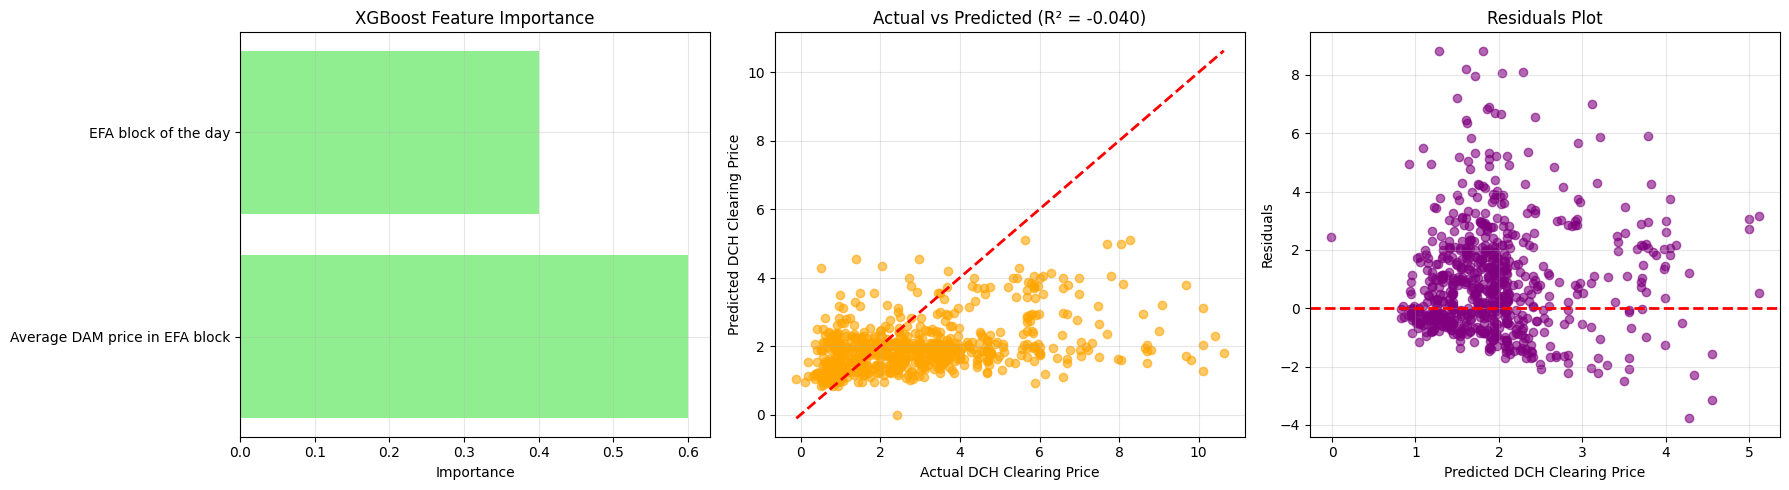


XGBoost Model Summary:
Cross-validation R²: -0.1142 ± 0.1325
Test R²: -0.0404 (-4.0% variance explained)
Most important feature: Average DAM price in EFA block


In [1]:
# XGBoost Model: Predict DCH Clearing Price using EFA Block + DAM Price
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

print("XGBoost Model: DCH Clearing Price Prediction")
print("="*60)

# Load and prepare data
df = pd.read_csv('DAM_DCH_Merged_Prices.csv')
df.columns = df.columns.str.strip()
df['Delivery day'] = pd.to_datetime(df['Delivery day'], format='%d/%m/%Y')
df = df.sort_values(['Delivery day', 'EFA block of the day']).reset_index(drop=True)

# Features and target
features = ['EFA block of the day', 'Average DAM price in EFA block']
target = 'Weighted_Avg_Clearing_Price'

X = df[features]
y = df[target]

# Chronological 80:20 Train-Test Split
split_index = int(0.8 * len(df))
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Training: {X_train.shape[0]} samples")
print(f"Testing: {X_test.shape[0]} samples")

# XGBoost Model Setup
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbosity=0
)

# Time Series Cross Validation (5 folds)
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(
    xgb_model, X_train, y_train, 
    cv=tscv, scoring='r2', n_jobs=-1
)

print(f"\nTime Series CV R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f}")
print(f"Std CV R²: {cv_scores.std():.4f}")

# Train Final Model
xgb_model.fit(X_train, y_train)

# Test Set Predictions
y_pred = xgb_model.predict(X_test)

# Model Evaluation
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nXGBoost Model Performance:")
print(f"Test R²: {r2:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

# Feature Importance
feature_importance = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print(f"\nFeature Importance:")
for _, row in importance_df.iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.4f}")

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Feature Importance
axes[0].barh(importance_df['Feature'], importance_df['Importance'], color='lightgreen')
axes[0].set_xlabel('Importance')
axes[0].set_title('XGBoost Feature Importance')
axes[0].grid(True, alpha=0.3)

# Actual vs Predicted
axes[1].scatter(y_test, y_pred, alpha=0.6, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual DCH Clearing Price')
axes[1].set_ylabel('Predicted DCH Clearing Price')
axes[1].set_title(f'Actual vs Predicted (R² = {r2:.3f})')
axes[1].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred
axes[2].scatter(y_pred, residuals, alpha=0.6, color='purple')
axes[2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Predicted DCH Clearing Price')
axes[2].set_ylabel('Residuals')
axes[2].set_title('Residuals Plot')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nXGBoost Model Summary:")
print(f"Cross-validation R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Test R²: {r2:.4f} ({r2*100:.1f}% variance explained)")
print(f"Most important feature: {importance_df.iloc[0]['Feature']}")